# Housing Data Analysis Project Overview

This notebook will analyze data from the King County House Sales dataset. This dataset contains various information on homes in King County. I will use this data in order to create linear regression models with the purpose of determining which features are most relevant in predicting housing prices. I will then examine the models' output and compare and contrast to determine which model performs best according to error metrics.

## Business Case/Problem

Hypothetical Situation: A King County real estate agency is looking to provide advice to home owners on what factors are most important in determining the value of their home. Using several multiple linear regression models I will examine which independant variables are most useful at predicting the dependant variable of home price. The regression models will help in providing home owners with relevant information regarding the price of their home should they be interested in listing their home with the real estate agency. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn import metrics
from sklearn.neighbors import DistanceMetric
from math import radians
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
#Function to drop unimportant columns from the dataframe.
def filter_columns(df):
    columns_to_keep = ['price','bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode',
                       'sqft_living15',
                       'sqft_lot15',
                      'lat',
                      'long']
    return df[columns_to_keep]

In [3]:
def errors(y_train, y_train_pred, y_test, y_test_pred):
    print('Train Mean Absolute Error:', round(metrics.mean_absolute_error(y_train, y_train_pred)))
    print('Test Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_test_pred)))
    print('Train Mean Squared Error:', round(metrics.mean_squared_error(y_train, y_train_pred)))
    print('Test Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_test_pred)))
    print('Train Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))))
    print('Test Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))))

In [4]:
def plot_model(test, test_pred, title):    
    plt.figure(figsize=(12,8))
    plt.scatter(test, test_pred)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(title);

In [5]:
#Create a function to determine the distance of the homes from a certain point (Seattle).
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

## Data Description
The data used in this project will provide the following information;

 - ID - unique identified for a house

 - Date - house was sold

 - Price - is prediction target

 - Bedrooms - number of Bedrooms/House

 - Bathrooms - number of bathrooms/bedrooms

 - Sqft_livingsquare - footage of the home

 - Sqft_lotsquare - footage of the lot

 - FloorsTotal - floors (levels) in house

 - Waterfront - House which has a view to a waterfront

 - View - Has been viewed

 - Condition - How good the condition is ( Overall )

 - Grade - overall grade given to the housing unit, based on King County grading system

 - Sqft_above - square footage of house apart from basement

 - Sqft_basement - square footage of the basement

 - Yr_built - Built Year

 - Yr_renovated - Year when house was renovated

 - Zipcode - zip

 - Lat - Latitude coordinate

 - Long - Longitude coordinate

 - Sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

 - Sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Load Data

In [6]:
#Load the Kings County housing data for analysis.
df = pd.read_csv('data/kc_house_data.csv')

In [7]:
df.shape

(21597, 21)

In [8]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [9]:
# Review remaining columns to see which ones make the most sense to keep.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.
- 'date': likely not relevant to business problem.
- 'id': likely not relevant to business problem.
- 'waterfront': large number of missing data.
- 'view': likely not relevant to business problem.
- 'yr_renovated': likely not relevant to business problem.
- 'lat': likely not relevant to business problem.
- 'long': likely not relevant to business problem.
- 'sqft_living15': already have data on sqft living.
- 'sqft_lot15': already have data on sqft lot.

## Data Cleaning

In [10]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [11]:
#Create new dataframe containing only relevant features.
df_filtered = filter_columns(df)

In [12]:
#Review new dataeframe for analysis.
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   condition      21597 non-null  int64  
 7   grade          21597 non-null  int64  
 8   sqft_above     21597 non-null  int64  
 9   yr_built       21597 non-null  int64  
 10  zipcode        21597 non-null  int64  
 11  sqft_living15  21597 non-null  int64  
 12  sqft_lot15     21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 2.5 MB


In [13]:
df_filtered.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,lat,long
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,98077.951845,1986.620318,12758.283512,47.560093,-122.213982
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,53.513072,685.230472,27274.441950,0.138552,0.140724
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,399.000000,651.000000,47.155900,-122.519000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,1490.000000,5100.000000,47.471100,-122.328000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,1840.000000,7620.000000,47.571800,-122.231000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,2360.000000,10083.000000,47.678000,-122.125000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,6210.000000,871200.000000,47.777600,-121.315000


In [14]:
#Set graph style
plt.style.use('fivethirtyeight')

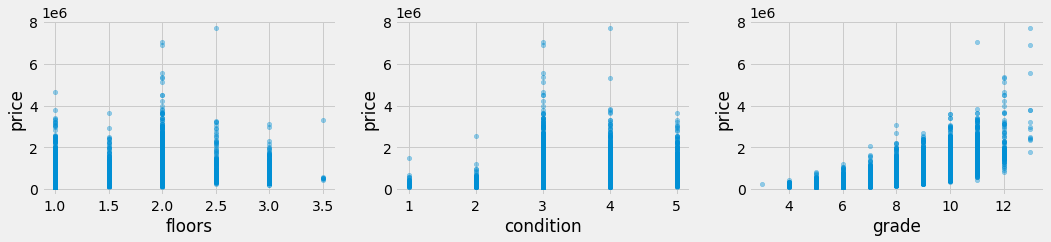

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['floors',
                     'condition',
                     'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4)

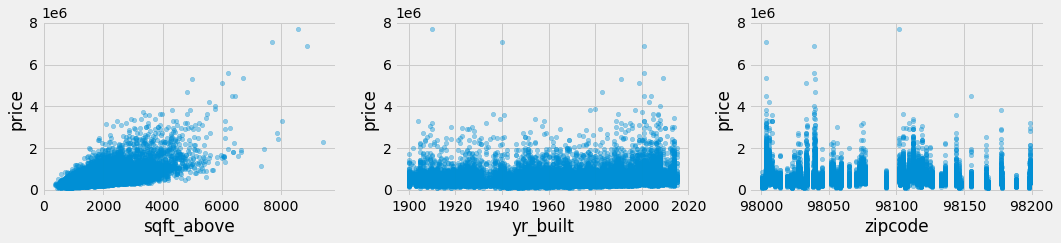

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_above',
                    'yr_built',
                    'zipcode'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4)

Looking at the above graphs it appears that 'zipcode', 'floors', and 'condition' could be considered categorical data, which will need to be addressed later. Will likely leave 'grade' as numerical data since it appears that a higher grade equates to a higher home price.

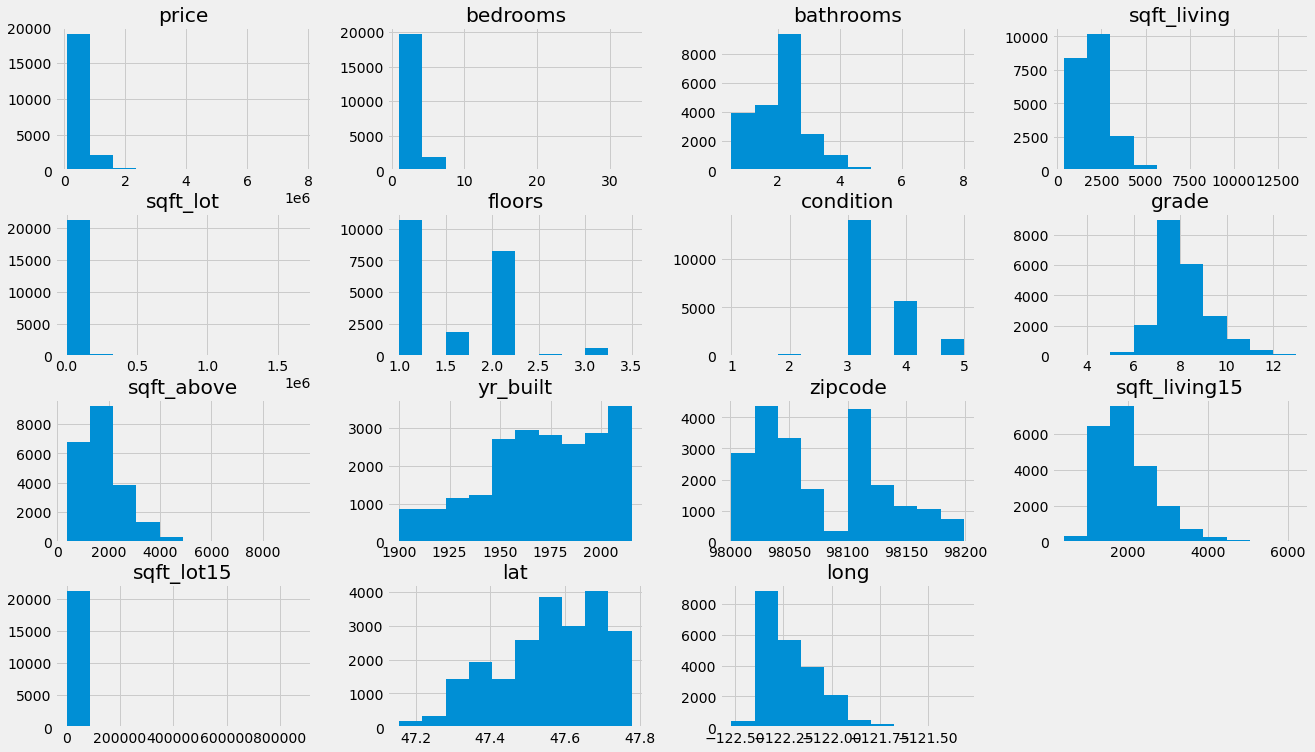

In [18]:
#Create histograms to further analyze the distribution of the features.
fig = plt.figure(figsize = (20,12))
ax = fig.gca()
df_filtered.hist(ax = ax);

Looking at the above graphs it appears that 'price', 'bedrooms', 'bathrooms', sqft_living', 'sqft_lot', and 'sqft_above', and 'yr_built' are not evenly distributed. This is likely due to outliers in the data. Outliers will need to be removed for these and some may need to be log transformed.

### Check for Multicollinearity

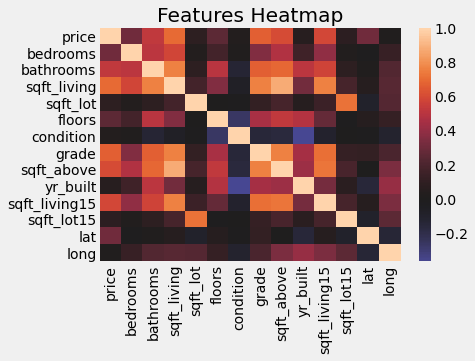

In [179]:
#Created heatmap to determine the multicollinearity of the features. 
sns.heatmap(df_filtered.corr(), center=0).set(title='Features Heatmap');

Noticed that 'sqft_above' and 'sqft_living' are closely related to each other and should not be included together in any models.

# Model A (Vanilla Classifier)

Will create a basic model without transforming any features just to get an idea of how the data performs. 

## Feature Engineering

In [20]:
#Model A features:
price_a = df_filtered['price']
bedrooms_a = df_filtered['bedrooms']
bathrooms_a = df_filtered['bathrooms']
sqft_living_a = df_filtered['sqft_living']
grade_a = df_filtered['grade']

In [21]:
#Create dataframe for features.
simple_model_ols = pd.concat([price_a, bedrooms_a, bathrooms_a, sqft_living_a, grade_a], axis=1)
simple_model_ols.head()

,price,bedrooms,bathrooms,sqft_living,grade
0,221900.0,3,1.00,1180,7
1,538000.0,3,2.25,2570,7
2,180000.0,2,1.00,770,6
3,604000.0,4,3.00,1960,7
4,510000.0,3,2.00,1680,8


### Split Data into Training and Test set

In [135]:
#Will seperate data into training and testing sets for analysis.
target_a = simple_model_ols['price']
features_a = simple_model_ols.drop(['price'], axis=1)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(features_a,target_a,test_size=0.2,random_state=42)

## Model A Training

In [23]:
outcome_a = 'y_train_a'
predictors_a = X_train_a
pred_sum_a = '+'.join(predictors_a.columns)
formula_a = outcome_a + '~' + pred_sum_a

In [24]:
data_a = pd.concat([X_train_a,y_train_a], axis=1)
data_a.head()

,bedrooms,bathrooms,sqft_living,grade,price
6243,4,2.00,1440,7,332500.0
8986,3,1.75,1430,7,390000.0
9419,4,2.75,3120,9,800000.0
10155,4,2.50,2060,7,462000.0
10436,3,2.00,2500,7,695000.0


In [25]:
#Create OLS Model to analyze Model A.
model_a_ols = ols(formula=formula_a, data=data_a).fit()
model_a_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_a   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     5184.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:40:43   Log-Likelihood:            -2.3917e+05
No. Observations:               17277   AIC:                         4.783e+05
Df Residuals:                   17272   BIC:                         4.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -4.87e+05    1.7e+04    -28.689      0.000    -5.2e+05   -4.54e+05
bedrooms    -4.335e+04   2685.131    -16.143      0.000   -4.86e+04   -3.81e+04
bathrooms   -2.448e+04   3936.106     -6.219      0.000   -3.22e+04   -1.68e+04
sqft_living   227.8517      4.065     56.054      0.000     219.884     235.819
grade        9.819e+04   2607.614     37.654      0.000    9.31e+04    1.03e+05
==============================================================================
Omnibus:                    12674.639   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           584848.422
Skew:                           3.045   Prob(JB):                         0.00
Kurtosis:                      30.845   Cond. No.                     2.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model A Evaluation

Model A produces p-values of 0 for each feature indicating that there likely is a relationship between the features and the target, which allows us to reject the null hypothesis for these features.  Model A, however, also produces a low R-squared value of .546, indicating that only about 54% of the model's observed variance can be explained by its inputs. Model A also produces a high Skew of 3.045, indicating that the data is not evenly distributed and will need to be transformed. Model A also has a high Kurtosis of 30.845 indicating a heavy tail and the presance of outliers.   

In [26]:
#Create linear regression model using Sklearn.
simple_model = LinearRegression()
simple_model.fit(X_train_a,y_train_a)

LinearRegression()

In [27]:
#Run model on training and testing data.
y_train_pred_a = simple_model.predict(X_train_a)
y_test_pred_a = simple_model.predict(X_test_a)

In [28]:
errors(y_train_a, y_train_pred_a, y_test_a, y_test_pred_a)

Train Mean Absolute Error: 163322
Test Mean Absolute Error: 160590
Train Mean Squared Error: 61861240256
Test Mean Squared Error: 60591750009
Train Root Mean Squared Error: 248719
Test Root Mean Squared Error: 246154


 - On average Model A predicts home prices within $160,590 of the true value.

In [29]:
#Calculate Model A residuals in order to use for graphs.
resid_a = y_test_pred_a - y_test_a

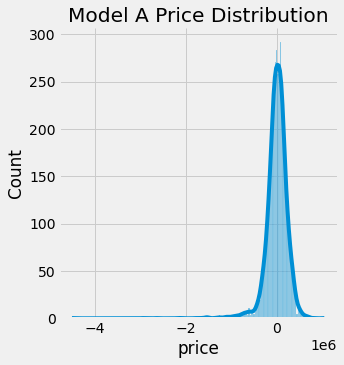

In [30]:
#Create distribution plot to check Model A's distribution of prices.
sns.displot(x=resid_a,kind='hist',kde=True)
plt.title('Model A Price Distribution');

Model A's distribution shows a long tail in the lower price range to the left of the median price, likely indicating the prescence of outliers and confirming that the data is not evenly distributed.

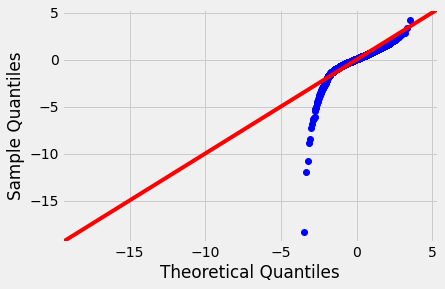

In [31]:
#Create qq plot to further analyze the distribution of the data.
fig = sm.graphics.qqplot(resid_a, dist=stats.norm, line='45',fit=True)

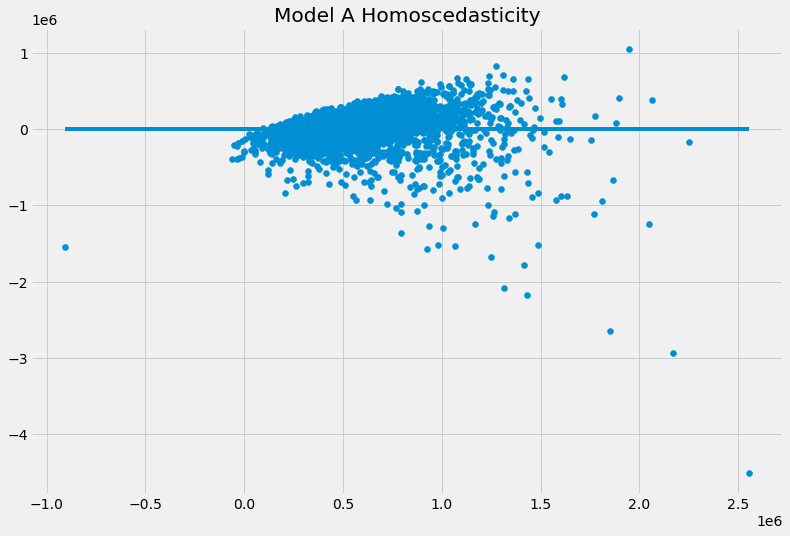

In [156]:
plot_scatter(y_test_pred_a, resid_a, 'Model A Homoscedasticity')

The data appears to be bunched to the left and appears to be heteroscedastic.

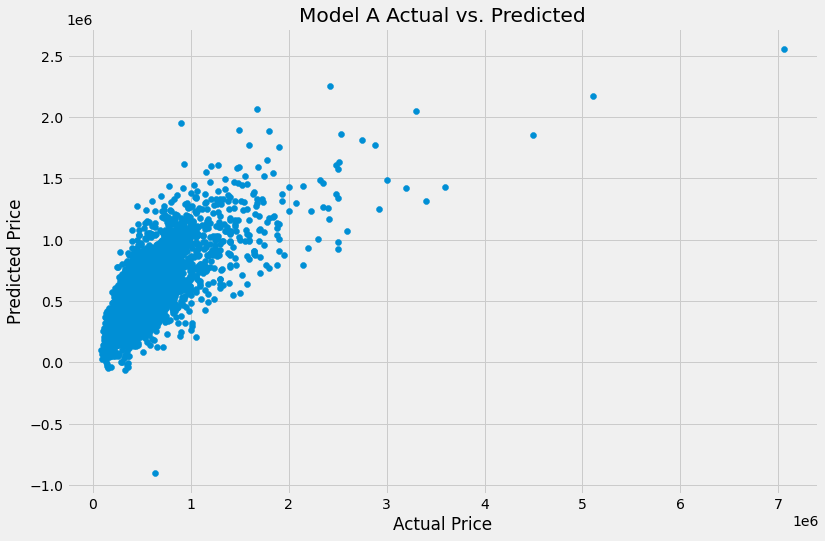

In [33]:
plot_model(y_test_a, y_test_pred_a, 'Model A Actual vs. Predicted')

The actual vs. predicted chart shows that Model A does not appear to follow a strong linear pattern. 

# Model B

## Feature Engineering

### Create Dummy Variables

In [34]:
#Create dummy variables for zipcode data as this would make more sense as a categorical feature.
df_filtered['zipcode'] = df_filtered['zipcode'].astype('str')
df_filtered['yr_built'] = df_filtered['yr_built'].astype('int64')
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   condition      21597 non-null  int64  
 7   grade          21597 non-null  int64  
 8   sqft_above     21597 non-null  int64  
 9   yr_built       21597 non-null  int64  
 10  zipcode        21597 non-null  object 
 11  sqft_living15  21597 non-null  int64  
 12  sqft_lot15     21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
dtypes: float64(5), int64(9), object(1)
memory usage: 2.5+ MB


In [35]:
#Create dummy variables and drop first column to avoid dummy variable trap.
zip_dummies = pd.get_dummies(df_filtered['zipcode'], prefix='zip', drop_first=True)

In [36]:
#Drop original zipcode column from the dataframe.
df_dummies = df_filtered.drop(['zipcode'], axis=1)

In [37]:
#Create new dataframe with the dummy variable columns.
df_dummies = pd.concat([df_filtered, zip_dummies], axis=1)
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_dummies.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,...,0.013335,0.002639,0.020651,0.011761,0.012455,0.011807,0.012131,0.006297,0.012965,0.014678
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,...,0.114708,0.051307,0.142216,0.107811,0.110909,0.108020,0.109475,0.079106,0.113125,0.120263
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model B Training

In [39]:
#Create Model B features, which will be scaled in order to be able to compare between eachother more easily.
price_b = df_dummies['price']
bedrooms_b = df_dummies['bedrooms']
scaled_bed_b = (bedrooms_b-np.mean(bedrooms_b))/np.sqrt(np.var(bedrooms_b))
bathrooms_b = df_dummies['bathrooms']
scaled_bath_b = (bathrooms_b-np.mean(bathrooms_b))/np.sqrt(np.var(bathrooms_b))
#Log transform 'sqft_living' in order to make it more evenly distributed.
logsqft = np.log(df_filtered['sqft_living'])
scaled_sqft = (logsqft-np.mean(logsqft))/np.sqrt(np.var(logsqft))
zip_dummies
yr_b = df_dummies['yr_built']
scaled_yr_b = (yr_b-np.mean(yr_b))/np.sqrt(np.var(yr_b))

In [40]:
model_b = pd.concat([price_b, scaled_bed_b, scaled_bath_b, scaled_sqft, zip_dummies, scaled_yr_b], axis=1)
model_b.head()

,price,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_built
0,221900.0,-0.402903,-1.451073,-1.125582,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-0.544678
1,538000.0,-0.402903,0.174486,0.709463,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.680850
2,180000.0,-1.482493,-1.451073,-2.131943,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.293626
3,604000.0,0.676687,1.149821,0.070676,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.204247
4,510000.0,-0.402903,-0.150626,-0.292732,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.544700


### Split Data into Training and Test Set

In [41]:
#Split data into training and testing sets for analysis.
target_b = model_b['price']
features_b = model_b.drop(['price'], axis=1)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features_b,target_b,test_size=0.2,random_state=42)
X_train_b.head()

,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_built
6243,0.676687,-0.150626,-0.656140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.034054
8986,-0.402903,-0.475738,-0.672568,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.306399
9419,0.676687,0.824709,1.166643,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.327691
10155,0.676687,0.499597,0.187988,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.102140
10436,-0.402903,-0.150626,0.644360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.668099


In [42]:
outcome_b = 'y_train_b'
predictors_b = X_train_b
pred_sum_b = '+'.join(predictors_b.columns)
formula_b = outcome_b + '~' + pred_sum_b

In [43]:
data_b = pd.concat([X_train_b,y_train_b], axis=1)
data_b.head()

,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_built,price
6243,0.676687,-0.150626,-0.656140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.034054,332500.0
8986,-0.402903,-0.475738,-0.672568,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.306399,390000.0
9419,0.676687,0.824709,1.166643,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.327691,800000.0
10155,0.676687,0.499597,0.187988,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.102140,462000.0
10436,-0.402903,-0.150626,0.644360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.668099,695000.0


In [44]:
#Create Model B OLS model. 
model_b_ols = ols(formula=formula_b, data=data_b).fit()
model_b_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_b   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     474.4
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:40:46   Log-Likelihood:            -2.3645e+05
No. Observations:               17277   AIC:                         4.730e+05
Df Residuals:                   17203   BIC:                         4.736e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.243e+05   1.27e+04     25.543      0.000    2.99e+05    3.49e+05
bedrooms    -4.388e+04   2227.983    -19.693      0.000   -4.82e+04   -3.95e+04
bathrooms    7.273e+04   2869.427     25.345      0.000    6.71e+04    7.84e+04
sqft_living  1.822e+05   2928.076     62.233      0.000    1.76e+05    1.88e+05
zip_98002    1.841e+04   2.15e+04      0.857      0.392   -2.37e+04    6.05e+04
zip_98003    1.226e+04   1.91e+04      0.640      0.522   -2.53e+04    4.98e+04
zip_98004    8.406e+05   1.86e+04     45.187      0.000    8.04e+05    8.77e+05
zip_98005      3.7e+05   2.23e+04     16.595      0.000    3.26e+05    4.14e+05
zip_98006     3.71e+05   1.68e+04     22.115      0.000    3.38e+05    4.04e+05
zip_98007    2.711e+05   2.37e+04     11.423      0.000    2.25e+05    3.18e+05
zip_98008    3.186e+05   1.89e+04     16.835      0.000    2.82e+05    3.56e+05
zip_98010     1.13e+05   2.65e+04      4.268      0.000    6.11e+04    1.65e+05
zip_98011    1.211e+05   2.14e+04      5.650      0.000    7.91e+04    1.63e+05
zip_98014    1.305e+05   2.42e+04      5.394      0.000    8.31e+04    1.78e+05
zip_98019    7.922e+04   2.15e+04      3.679      0.000     3.7e+04    1.21e+05
zip_98022    5.257e+04   2.02e+04      2.608      0.009    1.31e+04    9.21e+04
zip_98023   -8155.1632   1.64e+04     -0.496      0.620   -4.04e+04    2.41e+04
zip_98024    2.205e+05   2.85e+04      7.748      0.000    1.65e+05    2.76e+05
zip_98027    2.014e+05   1.71e+04     11.753      0.000    1.68e+05    2.35e+05
zip_98028    1.207e+05   1.91e+04      6.331      0.000    8.33e+04    1.58e+05
zip_98029    2.291e+05   1.85e+04     12.399      0.000    1.93e+05    2.65e+05
zip_98030   -3267.1419   1.97e+04     -0.166      0.869    -4.2e+04    3.54e+04
zip_98031    5182.1303   1.91e+04      0.272      0.786   -3.22e+04    4.25e+04
zip_98032    2.485e+04   2.48e+04      1.002      0.316   -2.38e+04    7.35e+04
zip_98033     4.13e+05   1.72e+04     23.944      0.000    3.79e+05    4.47e+05
zip_98034    2.237e+05   1.61e+04     13.868      0.000    1.92e+05    2.55e+05
zip_98038    1.955e+04   1.61e+04      1.213      0.225    -1.2e+04    5.11e+04
zip_98039    1.575e+06   3.47e+04     45.333      0.000    1.51e+06    1.64e+06
zip_98040    6.805e+05   1.92e+04     35.469      0.000    6.43e+05    7.18e+05
zip_98042    2.472e+04   1.63e+04      1.519      0.129   -7176.123    5.66e+04
zip_98045    1.304e+05      2e+04      6.515      0.000    9.12e+04     1.7e+05
zip_98052    2.527e+05   1.61e+04     15.680      0.000    2.21e+05    2.84e+05
zip_98053    2.512e+05   1.76e+04     14.272      0.000    2.17e+05    2.86e+05
zip_98055    3.973e+04    1.9e+04      2.086      0.037    2389.012    7.71e+04
zip_98056     1.26e+05   1.73e+04      7.261      0.000     9.2e+04     1.6e+05
zip_98058    4.219e+04    1.7e+04      2.48

## Model B Evaluation

While Model B produces a better R-squared value of .668 than Model A there are also high p-values for some of zip code dummy variables, meaning that these high p-values are insignificant for the model and will need to be removed. Model B also produces a higher Skew than Model A at 4.983, indicating that the data is less evenly distributed and will need to be transformed. Model B also has a much higher Kurtosis of 69.100 indicating more outliers than Model A, this is likely due to the high p-value dummy variables that will need to removed.

In [45]:
#Create linear regression model using Sklearn.
model_b_lr = LinearRegression()
model_b_lr.fit(X_train_b,y_train_b)

LinearRegression()

In [46]:
#Run model on training and testing data.
y_train_pred_b = model_b_lr.predict(X_train_b)
y_test_pred_b = model_b_lr.predict(X_test_b)

In [47]:
errors(y_train_b, y_train_pred_b, y_test_b, y_test_pred_b)

Train Mean Absolute Error: 124110
Test Mean Absolute Error: 122502
Train Mean Squared Error: 45177935021
Test Mean Squared Error: 46626531192
Train Root Mean Squared Error: 212551
Test Root Mean Squared Error: 215932


On average Model B predicts home prices within $122,502 of the true home value.

In [48]:
#Calculate Model B residuals in order to use for graphs.
resid_b = y_test_pred_b - y_test_b

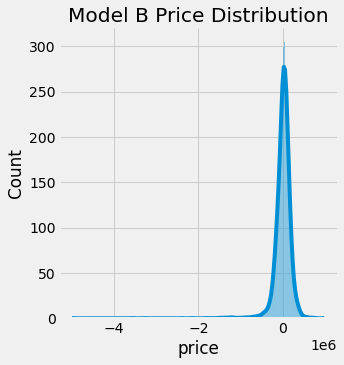

In [49]:
#Create distribution plot to check Model B's distribution of prices.
sns.displot(x=resid_b,kind='hist',kde=True)
plt.title('Model B Price Distribution');

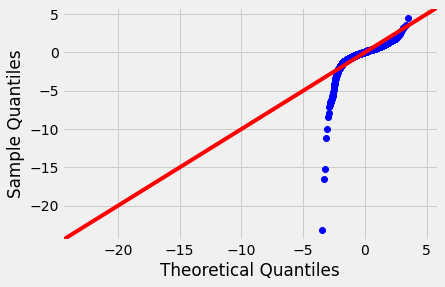

In [50]:
#Create qq plot to further analyze the distribution of the data.
fig = sm.graphics.qqplot(resid_b, dist=stats.norm, line='45',fit=True)

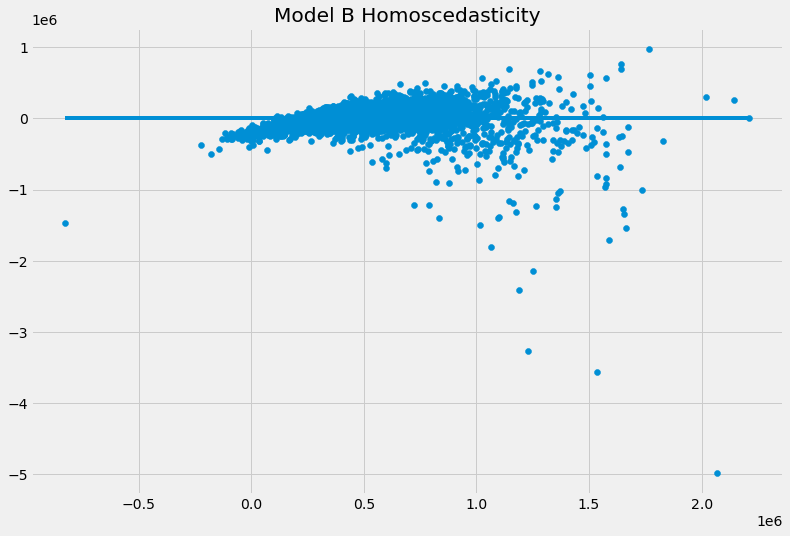

In [155]:
plot_scatter(y_test_pred_b, resid_b, 'Model B Homoscedasticity')

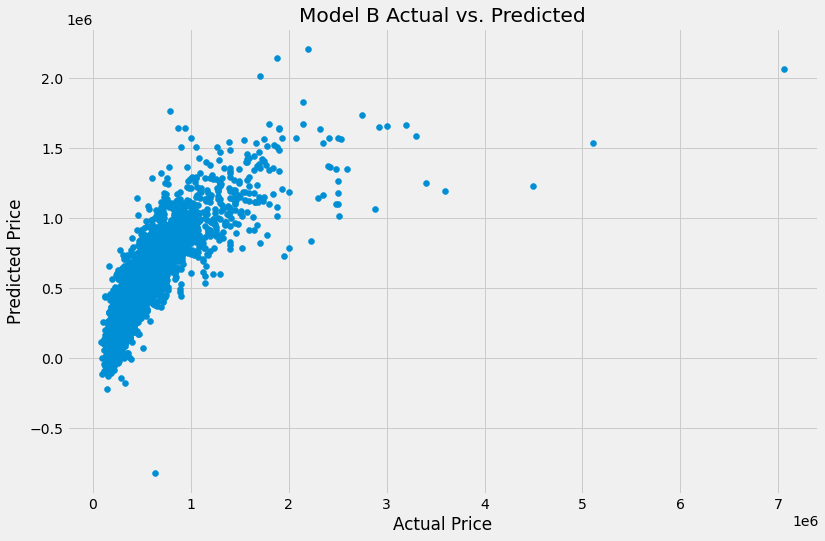

In [52]:
plot_model(y_test_b, y_test_pred_b, 'Model B Actual vs. Predicted')

# Model C

## Remove Outliers

 - Will remove outliers for certain features in order to make the data more normally distributed and address high skewness and kurtosis from Model's A and B.

In [53]:
df_filtered.bathrooms.mean()

2.1158262721674306

In [54]:
df_filtered.bathrooms.std()

0.7689842966527209

In [55]:
df_filtered.bedrooms.mean()

3.3731999814789093

In [56]:
df_filtered.bedrooms.std()

0.9262988945421479

In [57]:
#Find the upper limit of three standard deviations for 'bathrooms'. 
upper_limit = df_filtered.bathrooms.mean() + 3*df_filtered.bathrooms.std()
upper_limit

4.422779162125593

In [58]:
#Find the upper limit of three standard deviations for 'bedrooms'.
upper_limit_beds = df_filtered.bedrooms.mean() + 3*df_filtered.bedrooms.std()
upper_limit_beds

6.152096665105352

In [59]:
#Find the lower limit of three deviations for 'bathrooms'.
lower_limit = df_filtered.bathrooms.mean() - 3*df_filtered.bathrooms.std()
lower_limit

-0.19112661779073248

In [60]:
#Find the lower limit of three standard deviations for 'bedrooms'.
lower_limit_beds = df_filtered.bedrooms.mean() - 3*df_filtered.bedrooms.std()
lower_limit_beds

0.5943032978524658

In [61]:
#Find the upper limit of three standard deviations for 'price'.
upper_limit_price = df_filtered.price.mean() + 3*df_filtered.price.std()
upper_limit_price

1642400.9938097629

In [62]:
#Find the lower limit of three standard deviations for 'price'.
lower_limit_price = df_filtered.price.mean() - 3*df_filtered.price.std()
lower_limit_price

-561807.8467986039

In [63]:
#Create new dataframe removing the upper and lower limit outliers for 'bathrooms', 'bedrooms', and 'price'.
df_outliers=df_filtered[(df_filtered.bathrooms<upper_limit) & (df_filtered.bathrooms>lower_limit) 
                        & (df_filtered.bedrooms<upper_limit_beds) & (df_filtered.bedrooms>lower_limit_beds)
                       & (df_filtered.price<upper_limit_price) & (df_filtered.price>lower_limit_price)]
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21040 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21040 non-null  float64
 1   bedrooms       21040 non-null  int64  
 2   bathrooms      21040 non-null  float64
 3   sqft_living    21040 non-null  int64  
 4   sqft_lot       21040 non-null  int64  
 5   floors         21040 non-null  float64
 6   condition      21040 non-null  int64  
 7   grade          21040 non-null  int64  
 8   sqft_above     21040 non-null  int64  
 9   yr_built       21040 non-null  int64  
 10  zipcode        21040 non-null  object 
 11  sqft_living15  21040 non-null  int64  
 12  sqft_lot15     21040 non-null  int64  
 13  lat            21040 non-null  float64
 14  long           21040 non-null  float64
dtypes: float64(5), int64(9), object(1)
memory usage: 2.6+ MB


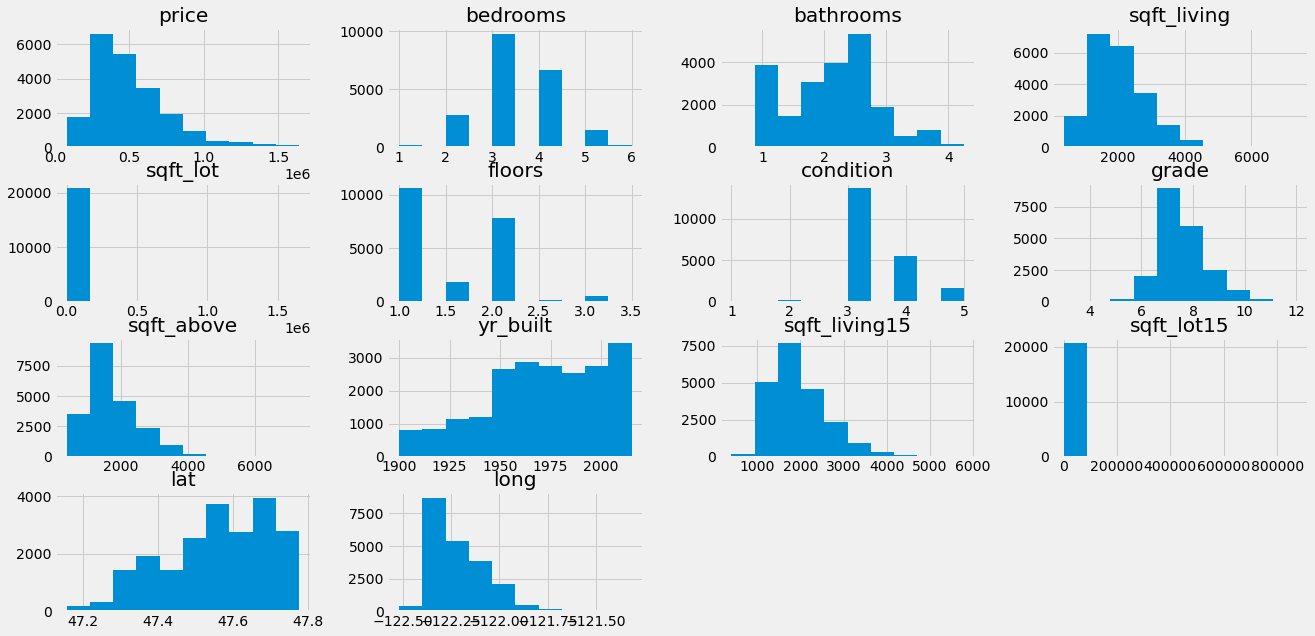

In [136]:
#Check new distributions of the features.
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_outliers.hist(ax = ax);

In [65]:
zip_dummies_c = pd.get_dummies(df_outliers['zipcode'], prefix='zip', drop_first=True)

In [66]:
#Update zip dummies to remove the zip codes with high p-values.
updated_zip_c = zip_dummies_c.drop(['zip_98002','zip_98003','zip_98022','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042','zip_98055','zip_98058','zip_98092',
                                  'zip_98188','zip_98168','zip_98178','zip_98188','zip_98148','zip_98198'], axis=1)
updated_zip_c.head()

,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98024,...,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
#Create Model C features, which will be scaled in order to be able to compare between eachother more easily.
model_c = pd.DataFrame([])
price_c = df_outliers['price']
bathrooms_c = df_outliers['bathrooms']
scaled_bath_c = (bathrooms_c-np.mean(bathrooms_c))/np.sqrt(np.var(bathrooms_c))
bedrooms_c = df_outliers['bedrooms']
scaled_bed_c = (bedrooms_c-np.mean(bedrooms_c))/np.sqrt(np.var(bedrooms_c))
#Will log transform 'sqft_lot' in order to get a more even distribution.
log_lot_c = np.log(df_outliers['sqft_lot'])
scaled_log_lot_c = (log_lot_c-np.mean(log_lot_c))/np.sqrt(np.var(log_lot_c))
updated_zip_c
sqfta_c = df_outliers['sqft_above']
scaled_sqfta_c = (sqfta_c-np.mean(sqfta_c))/np.sqrt(np.var(sqfta_c))

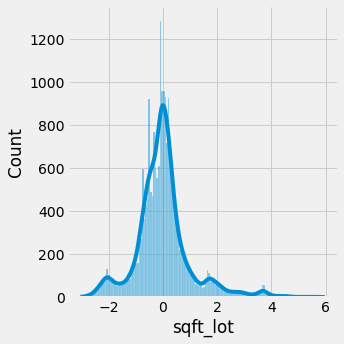

In [68]:
sns.displot(x=scaled_log_lot_c,kind='hist',kde=True);

## Model C Training

In [69]:
model_c = pd.concat([price_c, scaled_bath_c, scaled_log_lot_c, scaled_sqfta_c, updated_zip_c], axis=1)
model_c.head()

,price,bathrooms,sqft_lot,sqft_above,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,...,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199
0,221900.0,-1.509925,-0.372593,-0.740182,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,0.251155,-0.095442,0.568532,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,180000.0,-1.509925,0.264825,-1.282175,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1.307802,-0.509044,-0.912034,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,-0.101061,0.026804,-0.079215,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
model_c.describe()

,price,bathrooms,sqft_lot,sqft_above,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,...,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199
count,2.104000e+04,2.104000e+04,2.104000e+04,2.104000e+04,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,...,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000
mean,5.043270e+05,2.161347e-16,-4.754963e-16,1.242774e-16,0.010884,0.007700,0.021816,0.006559,0.013070,0.004705,...,0.019154,0.016778,0.023289,0.012357,0.015684,0.013688,0.020722,0.011835,0.011692,0.014306
std,2.565535e+05,1.000024e+00,1.000024e+00,1.000024e+00,0.103760,0.087411,0.146085,0.080723,0.113579,0.068435,...,0.137069,0.128440,0.150823,0.110478,0.124254,0.116196,0.142457,0.108144,0.107498,0.118752
min,7.800000e+04,-2.214356e+00,-3.035993e+00,-1.810949e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.199500e+05,-8.054929e-01,-5.088209e-01,-7.401823e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.450000e+05,2.511547e-01,-4.820231e-02,-2.642862e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.250000e+05,6.033705e-01,3.145553e-01,5.420933e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.640000e+06,3.068882e+00,5.966313e+00,7.376490e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
#Seperate Model C into training and testing datasets for analysis.
target_c = model_c['price']
features_c = model_c.drop(['price'], axis=1)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_c,target_c,test_size=0.2,random_state=42)
X_train_c.head()

,bathrooms,sqft_lot,sqft_above,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,...,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199
13008,0.603371,-0.402634,0.343803,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4152,-0.453277,-0.047464,-0.885595,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20018,0.603371,-0.738531,1.062935,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14003,-1.509925,0.101101,-0.766621,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2513,-1.509925,-0.233435,-1.401149,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
outcome_c = 'y_train_c'
predictors_c = X_train_c
pred_sum_c = '+'.join(predictors_c.columns)
formula_c = outcome_c + '~' + pred_sum_c

In [73]:
data_c = pd.concat([X_train_c,y_train_c], axis=1)
data_c.head()

,bathrooms,sqft_lot,sqft_above,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,...,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199,price
13008,0.603371,-0.402634,0.343803,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,360000.0
4152,-0.453277,-0.047464,-0.885595,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,222000.0
20018,0.603371,-0.738531,1.062935,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,415000.0
14003,-1.509925,0.101101,-0.766621,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,255000.0
2513,-1.509925,-0.233435,-1.401149,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,179900.0


In [74]:
#Creat Model C OLS model.
model_c_ols = ols(formula=formula_c, data=data_c).fit()
model_c_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_c   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     946.3
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:40:56   Log-Likelihood:            -2.2160e+05
No. Observations:               16832   AIC:                         4.433e+05
Df Residuals:                   16776   BIC:                         4.437e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.024e+05   1951.983    154.939      0.000    2.99e+05    3.06e+05
bathrooms   4.795e+04   1323.293     36.234      0.000    4.54e+04    5.05e+04
sqft_lot    4.971e+04   1245.807     39.904      0.000    4.73e+04    5.22e+04
sqft_above  1.065e+05   1437.354     74.127      0.000    1.04e+05    1.09e+05
zip_98004   6.543e+05   9578.981     68.303      0.000    6.36e+05    6.73e+05
zip_98005   3.785e+05   1.13e+04     33.538      0.000    3.56e+05    4.01e+05
zip_98006   3.712e+05   6841.469     54.259      0.000    3.58e+05    3.85e+05
zip_98007   2.825e+05   1.23e+04     22.917      0.000    2.58e+05    3.07e+05
zip_98008   2.881e+05   8801.527     32.738      0.000    2.71e+05    3.05e+05
zip_98010   1.032e+04   1.43e+04      0.724      0.469   -1.76e+04    3.83e+04
zip_98011   1.385e+05   1.01e+04     13.755      0.000    1.19e+05    1.58e+05
zip_98014   2.997e+04   1.32e+04      2.264      0.024    4019.751    5.59e+04
zip_98019   3.225e+04   1.04e+04      3.110      0.002    1.19e+04    5.26e+04
zip_98024   8.919e+04   1.83e+04      4.874      0.000    5.33e+04    1.25e+05
zip_98027   2.009e+05   7215.798     27.843      0.000    1.87e+05    2.15e+05
zip_98028   1.396e+05   8614.078     16.204      0.000    1.23e+05    1.56e+05
zip_98029   2.316e+05   8290.689     27.933      0.000    2.15e+05    2.48e+05
zip_98033   3.671e+05   7363.016     49.861      0.000    3.53e+05    3.82e+05
zip_98034   2.003e+05   6496.010     30.836      0.000    1.88e+05    2.13e+05
zip_98039   8.736e+05   3.27e+04     26.699      0.000    8.09e+05    9.38e+05
zip_98040   5.732e+05   9346.056     61.328      0.000    5.55e+05    5.91e+05
zip_98045   4.941e+04   9773.943      5.055      0.000    3.02e+04    6.86e+04
zip_98052   2.663e+05   6229.461     42.740      0.000    2.54e+05    2.78e+05
zip_98053   1.919e+05   7665.764     25.035      0.000    1.77e+05    2.07e+05
zip_98056   1.046e+05   7326.516     14.278      0.000    9.02e+04    1.19e+05
zip_98059   8.971e+04   6801.964     13.189      0.000    7.64e+04    1.03e+05
zip_98065   8.992e+04   8435.187     10.661      0.000    7.34e+04    1.06e+05
zip_98070   9.815e+04   1.34e+04      7.337      0.000    7.19e+04    1.24e+05
zip_98072    1.56e+05   8716.139     17.895      0.000    1.39e+05    1.73e+05
zip_98074    2.18e+05   7156.621     30.461      0.000    2.04e+05    2.32e+05
zip_98075   2.394e+05   8080.671     29.630      0.000    2.24e+05    2.55e+05
zip_98077   1.314e+05   1.05e+04     12.542      0.000    1.11e+05    1.52e+05
zip_98102   5.523e+05   1.45e+04     38.168      0.000    5.24e+05    5.81e+05
zip_98103   3.965e+05   6240.258     63.539      0.000    3.84e+05    4.09e+05
zip_98105   5.346e+05   9956.559     53.697      0.000    5.15e+05    5.54e+05
zip_98106   1.439e+05   7943.538     18.115      0.000    1.28e+05    1.59e+05
zi

## Model C Evaluation

Model C produces a higher R-squared than both models A and B. Also the skew and kurtosis have both significantly decreased indicating more evenly distributed data. There is also one zip code with a high p-value likely due to the presence of an outlier. It also appears that sqft_above contributes more to the home price than does sqft_lot and bathrooms according to the coefficiants. Also looking at the coefficiants we can see that certain zip codes are the most important factor in determing the price of the home.  

In [75]:
model_c_lr = LinearRegression()
model_c_lr.fit(X_train_c,y_train_c)

LinearRegression()

In [76]:
y_train_pred_c = model_c_lr.predict(X_train_c)
y_test_pred_c = model_c_lr.predict(X_test_c)

In [77]:
errors(y_train_c, y_train_pred_c, y_test_c, y_test_pred_c)

Train Mean Absolute Error: 87682
Test Mean Absolute Error: 91518
Train Mean Squared Error: 15945451448
Test Mean Squared Error: 18263182375
Train Root Mean Squared Error: 126275
Test Root Mean Squared Error: 135141


In [78]:
resid_c = y_test_pred_c - y_test_c
resid_c

21069    187437.863327
21517         2.563221
18728    -36515.835068
7977      50536.534485
13857     47809.969836
             ...      
20428   -139783.497771
3124     -47928.073593
17074     83172.054751
4947      41058.526811
3849    -380447.549632
Name: price, Length: 4208, dtype: float64

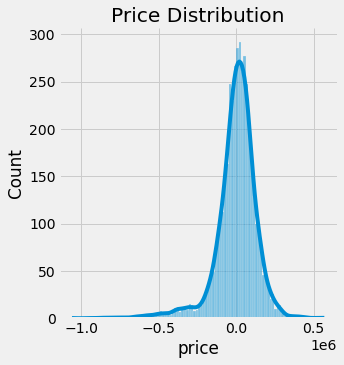

In [79]:
sns.displot(x=resid_c,kind='hist',kde=True)
plt.title('Price Distribution');

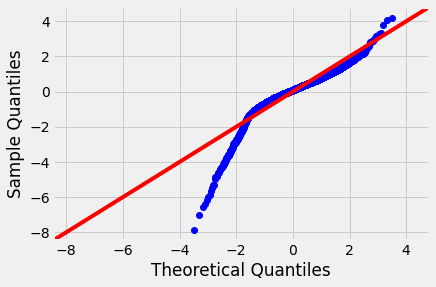

In [80]:
fig = sm.graphics.qqplot(resid_c, dist=stats.norm, line='45',fit=True)

In [151]:
def plot_scatter(y_test, resid, title):
    plt.figure(figsize=(12,8))
    plt.scatter(y_test, resid)
    plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
    plt.title(title);

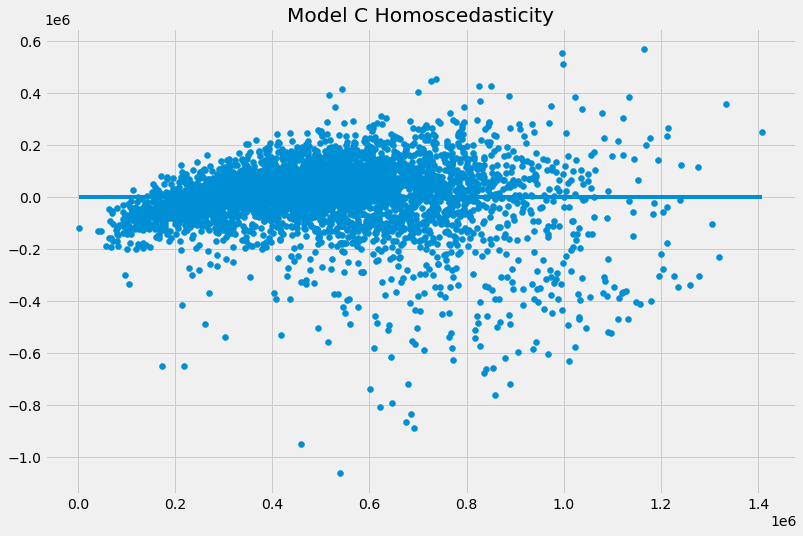

In [153]:
plot_scatter(y_test_pred_c, resid_c, 'Model C Homoscedasticity')

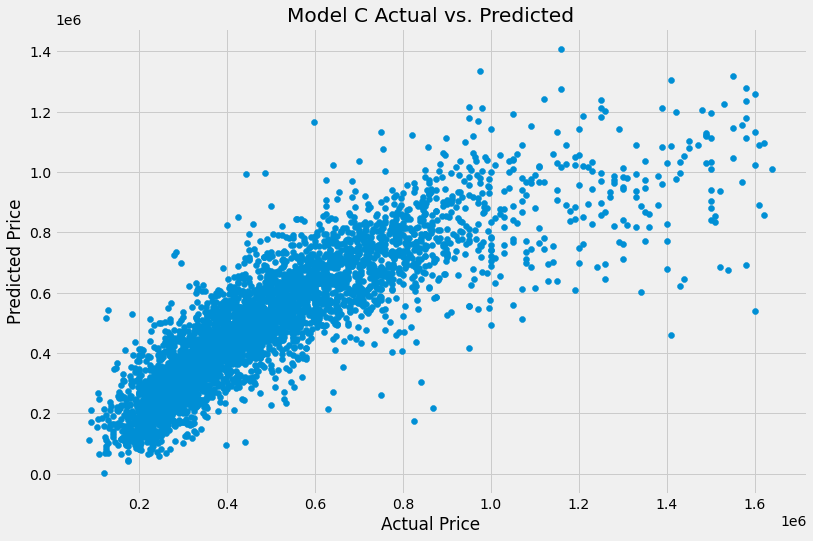

In [82]:
plot_model(y_test_c, y_test_pred_c, 'Model C Actual vs. Predicted')

# Model D

### Remove Outliers

In [83]:
df_filtered.sqft_living.std()

918.1061250800805

In [84]:
upper_limit_sqft = df_filtered.sqft_living.mean() + 3*df_filtered.sqft_living.std()
upper_limit_sqft

4834.640225497222

In [85]:
lower_limit_sqft = df_filtered.sqft_living.mean() - 3*df_filtered.sqft_living.std()
lower_limit_sqft

-673.9965249832612

In [86]:
df_filtered.sqft_lot.std()

41412.636875502074

In [87]:
upper_limit_lot = df_filtered.sqft_lot.mean() + 1*df_filtered.sqft_lot.std()
upper_limit_lot

56512.045635978066

In [88]:
lower_limit_lot = df_filtered.sqft_lot.mean() - 3*df_filtered.sqft_lot.std()
lower_limit_lot

-109138.50186603024

In [89]:
upper_limit_sqft15 = df_filtered.sqft_living15.mean() + 3*df_filtered.sqft_living15.std()
upper_limit_sqft15

4042.3117333371847

In [90]:
lower_limit_sqft15 = df_filtered.sqft_living15.mean() - 3*df_filtered.sqft_living15.std()
lower_limit_sqft15

-69.07109806376707

In [91]:
df_outliers_2=df_outliers[(df_filtered.sqft_living<upper_limit_sqft) & (df_filtered.sqft_living>lower_limit_sqft) 
                         & (df_filtered.sqft_lot<upper_limit_lot) & (df_filtered.sqft_lot>lower_limit_lot)
                        & (df_filtered.sqft_living15<upper_limit_sqft15) & (df_filtered.sqft_living15>lower_limit_sqft15)]
df_outliers_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20150 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20150 non-null  float64
 1   bedrooms       20150 non-null  int64  
 2   bathrooms      20150 non-null  float64
 3   sqft_living    20150 non-null  int64  
 4   sqft_lot       20150 non-null  int64  
 5   floors         20150 non-null  float64
 6   condition      20150 non-null  int64  
 7   grade          20150 non-null  int64  
 8   sqft_above     20150 non-null  int64  
 9   yr_built       20150 non-null  int64  
 10  zipcode        20150 non-null  object 
 11  sqft_living15  20150 non-null  int64  
 12  sqft_lot15     20150 non-null  int64  
 13  lat            20150 non-null  float64
 14  long           20150 non-null  float64
dtypes: float64(5), int64(9), object(1)
memory usage: 2.5+ MB


## Feature Engineering

Will create a new feature consisting of the sum of sqft living and the average sqft living of the nearest 15 neighbors. This should give a better idea of the price due to the grouping of homes in neighborhoods with larger homes also in the area.

In [92]:
sum_sqft_liv = df_outliers_2['sqft_living'] + df_outliers_2['sqft_living15']
df_outliers_2['sum_sqft_liv'] = sum_sqft_liv
df_outliers_2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,lat,long,sum_sqft_liv
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,1340,5650,47.5112,-122.257,2520
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,1690,7639,47.7210,-122.319,4260
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,98028,2720,8062,47.7379,-122.233,3490
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,1360,5000,47.5208,-122.393,3320
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,1800,7503,47.6168,-122.045,3480


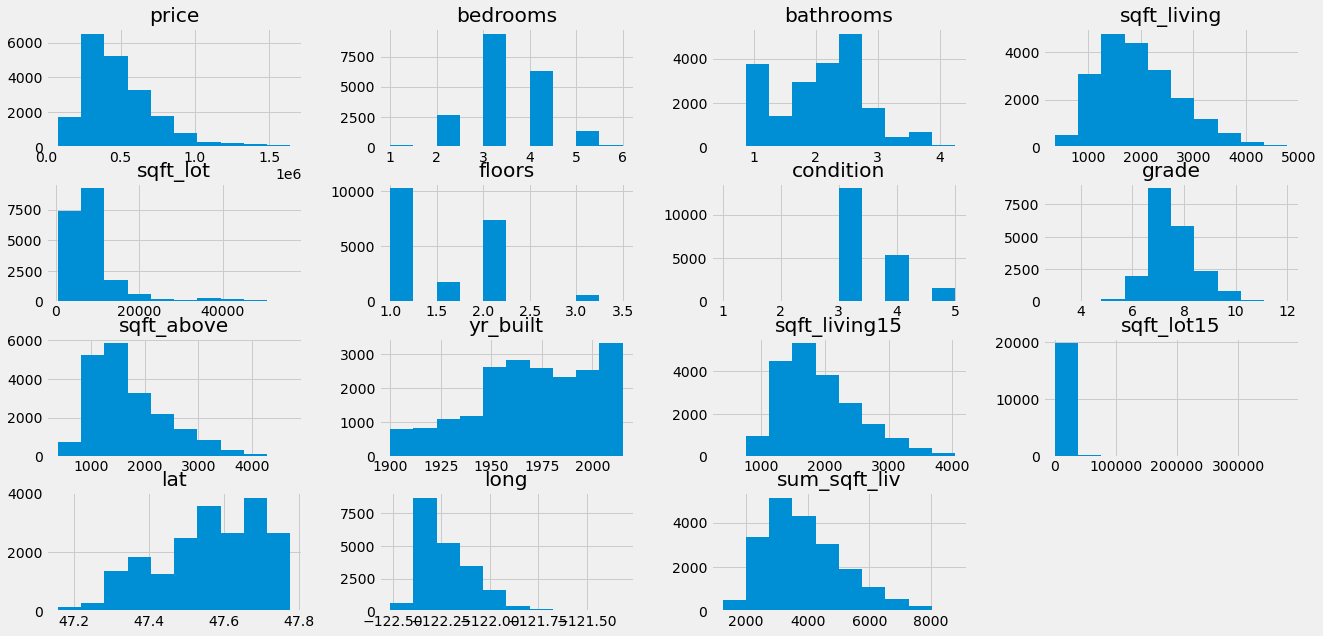

In [93]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_outliers_2.hist(ax = ax);

 - Will create a new feature conisisting of the distance from the homes to Seattle. I would expect home values to increase as they become closer to the city.

In [94]:
#Seattle Longitude/Latitude
start_lat, start_long = 47.6062, 122.3321

In [95]:
lat_a = df_outliers_2['lat']
long_a = df_outliers_2['long']

In [96]:
homes_lat_long = pd.concat([lat_a, long_a], axis=1)
homes_lat_long.head()

,lat,long
0,47.5112,-122.257
1,47.7210,-122.319
2,47.7379,-122.233
3,47.5208,-122.393
4,47.6168,-122.045


In [97]:
distances_km = []
for row in homes_lat_long.itertuples(index=False):
   distances_km.append(
       haversine_distance(start_lat, start_long, row.lat, row.long)
   )

In [98]:
homes_lat_long['Distance_From_Seattle'] = distances_km

In [99]:
homes_lat_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20150 entries, 0 to 21596
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    20150 non-null  float64
 1   long                   20150 non-null  float64
 2   Distance_From_Seattle  20150 non-null  float64
dtypes: float64(3)
memory usage: 629.7 KB


In [100]:
price_d = df_outliers_2['price']
grade_d = df_outliers_2['grade']
scaled_grade_d = (grade_d-np.mean(grade_d))/np.sqrt(np.var(grade_d))
bathrooms_d = df_outliers_2['bathrooms']
scaled_bath_d = (bathrooms_d-np.mean(bathrooms_d))/np.sqrt(np.var(bathrooms_d))
bedrooms_d = df_outliers_2['bedrooms']
scaled_bed_d = (bedrooms_d-np.mean(bedrooms_d))/np.sqrt(np.var(bedrooms_d))
sqft_living_d = df_outliers_2['sqft_living']
scaled_sqftl_d = (sqft_living_d-np.mean(sqft_living_d))/np.sqrt(np.var(sqft_living_d))
zip_dummies_d = pd.get_dummies(df_outliers_2['zipcode'], prefix='zip', drop_first=True)
updated_zip_d = zip_dummies_d.drop(['zip_98002','zip_98003','zip_98022','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042','zip_98055','zip_98058','zip_98092',
                                  'zip_98188','zip_98168','zip_98178','zip_98188','zip_98148','zip_98198'], axis=1)
log_yr_d = np.log(df_outliers_2['yr_built'])
scaled_yr_d = (log_yr_d-np.mean(log_yr_d))/np.sqrt(np.var(log_yr_d))

In [101]:
sum_sqft_liv_d = df_outliers_2['sum_sqft_liv']
scaled_sqft_liv = (sum_sqft_liv_d-np.mean(sum_sqft_liv_d))/np.sqrt(np.var(sum_sqft_liv_d))

In [102]:
distance = homes_lat_long['Distance_From_Seattle']
scaled_distance = (distance-np.mean(distance))/np.sqrt(np.var(distance))

## Model D Training

In [103]:
model_d = pd.concat([price_d, scaled_bath_d, scaled_distance, scaled_grade_d, scaled_sqft_liv, updated_zip_d, scaled_yr_d], axis=1)
model_d.head()

,price,bathrooms,Distance_From_Seattle,grade,sum_sqft_liv,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,...,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199,yr_built
0,221900.0,-1.508437,0.169598,-0.527070,-1.073561,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.514345
1,538000.0,0.283785,-1.285586,-0.527070,0.284419,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.650951
2,180000.0,-1.508437,-1.091936,-1.477193,-0.316526,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.269163
3,604000.0,1.359118,-0.353117,-0.527070,-0.449202,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.174050
4,510000.0,-0.074660,0.267827,0.423052,-0.324331,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.568543


In [104]:
target_d = model_d['price']
features_d = model_d.drop(['price'], axis=1)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(features_d,target_d,test_size=0.2,random_state=42)

In [105]:
outcome_d = 'y_train_d'
predictors_d = X_train_d
pred_sum_d = '+'.join(predictors_d.columns)
formula_d = outcome_d + '~' + pred_sum_d

In [106]:
data_d = pd.concat([X_train_d,y_train_d], axis=1)
data_d.head()

,bathrooms,Distance_From_Seattle,grade,sum_sqft_liv,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,...,zip_98133,zip_98136,zip_98144,zip_98146,zip_98155,zip_98166,zip_98177,zip_98199,yr_built,price
2558,1.359118,-0.773395,1.373174,0.495141,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.936762,612000.0
492,-0.433104,1.523748,-0.527070,-1.011125,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.072300,232000.0
18349,0.642229,1.306944,1.373174,1.431679,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.003493,622500.0
17270,0.642229,0.460776,1.373174,1.002432,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.970136,640000.0
15428,-0.791548,0.419379,-0.527070,-0.176045,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.616773,195000.0


In [107]:
model_d_ols = ols(formula=formula_d, data=data_d).fit()
model_d_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_d   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1157.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:41:04   Log-Likelihood:            -2.1022e+05
No. Observations:               16120   AIC:                         4.206e+05
Df Residuals:                   16062   BIC:                         4.210e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.532e+05   3680.370     95.962      0.000    3.46e+05     3.6e+05
bathrooms              1.982e+04   1379.839     14.366      0.000    1.71e+04    2.25e+04
Distance_From_Seattle -1.445e+04   2811.894     -5.140      0.000      -2e+04   -8940.200
grade                  6.509e+04   1530.970     42.518      0.000    6.21e+04    6.81e+04
sum_sqft_liv            1.02e+05   1641.106     62.153      0.000    9.88e+04    1.05e+05
zip_98004              5.495e+05   9478.449     57.979      0.000    5.31e+05    5.68e+05
zip_98005              2.651e+05   1.07e+04     24.786      0.000    2.44e+05    2.86e+05
zip_98006              2.345e+05   6963.045     33.672      0.000    2.21e+05    2.48e+05
zip_98007              2.007e+05   1.17e+04     17.220      0.000    1.78e+05    2.24e+05
zip_98008              2.124e+05   8307.600     25.570      0.000    1.96e+05    2.29e+05
zip_98010              1.084e+05   1.37e+04      7.901      0.000    8.15e+04    1.35e+05
zip_98011              6.359e+04   1.13e+04      5.633      0.000    4.15e+04    8.57e+04
zip_98014              1.226e+05   1.39e+04      8.793      0.000    9.52e+04     1.5e+05
zip_98019               5.31e+04   1.07e+04      4.946      0.000    3.21e+04    7.41e+04
zip_98024              1.274e+05   1.78e+04      7.171      0.000    9.26e+04    1.62e+05
zip_98027              1.559e+05   7196.016     21.668      0.000    1.42e+05     1.7e+05
zip_98028              6.927e+04   1.02e+04      6.766      0.000    4.92e+04    8.93e+04
zip_98029              1.816e+05   7468.448     24.321      0.000    1.67e+05    1.96e+05
zip_98033              3.113e+05   8168.725     38.105      0.000    2.95e+05    3.27e+05
zip_98034              1.377e+05   8167.257     16.858      0.000    1.22e+05    1.54e+05
zip_98039              7.445e+05   3.26e+04     22.818      0.000    6.81e+05    8.08e+05
zip_98040               4.34e+05   8830.950     49.144      0.000    4.17e+05    4.51e+05
zip_98045              1.085e+05      1e+04     10.836      0.000    8.89e+04    1.28e+05
zip_98052              1.907e+05   7131.425     26.740      0.000    1.77e+05    2.05e+05
zip_98053              2.005e+05   8073.721     24.834      0.000    1.85e+05    2.16e+05
zip_98056              8.263e+04   6716.578     12.302      0.000    6.95e+04    9.58e+04
zip_98059              6.695e+04   6505.173     10.291      0.000    5.42e+04    7.97e+04
zip_98065              9.898e+04   8076.837     12.255      0.000    8.32e+04    1.15e+05
zip_98070              1.457e+05    1.6e+04      9.084      0.000    1.14e+05    1.77e+05
zip_98072              1.061e+05   1.01e+04     10.458      0.000    8.63e+04    1.26e+05
zip_98074              1.486e+05   6967.261     21.332      0.000    1.35e+05    1.62e+05
zip_98075              

## Model D Evalutation

Model D produces a slighly higher R-squared than Model C at .805. Model D also has significantly lower skew and kurtosis than both Model's A and B while being fairly similar to Model C. All of the p-values in Model D are 0 indicating that all of the features statistically significant. Also looking at the coefficiants it appears that grade and year built contribute more to the home price than bathrooms and distance from Seattle. Finally square foot living as well as certain zip codes appear to be the most significant factors in contributing to the home price according to the coefficiants, this is similar to what was observed in both Model's B and C.

In [108]:
model_d_lr = LinearRegression()
model_d_lr.fit(X_train_d, y_train_d)

LinearRegression()

In [109]:
y_train_pred_d = model_d_lr.predict(X_train_d)
y_test_pred_d = model_d_lr.predict(X_test_d)

In [110]:
errors(y_train_d, y_train_pred_d, y_test_d, y_test_pred_d)

Train Mean Absolute Error: 77769
Test Mean Absolute Error: 77473
Train Mean Squared Error: 12437376298
Test Mean Squared Error: 12325876562
Train Root Mean Squared Error: 111523
Test Root Mean Squared Error: 111022


In [111]:
resid_d = y_test_pred_d - y_test_d
resid_d

10669     62624.691092
11113    -34256.955955
5896    -123948.120457
6285      39671.342458
10350     75347.921184
             ...      
1123     240338.756242
8618      88413.727019
17688   -162505.977226
20451   -187189.931386
13126    -28426.300628
Name: price, Length: 4030, dtype: float64

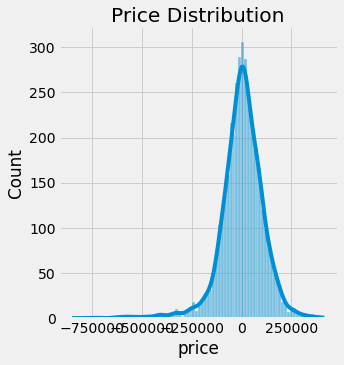

In [112]:
sns.displot(x=resid_d,kind='hist',kde=True)
plt.title('Price Distribution');

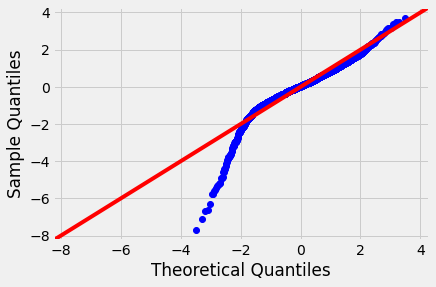

In [113]:
fig = sm.graphics.qqplot(resid_d, dist=stats.norm, line='45',fit=True)

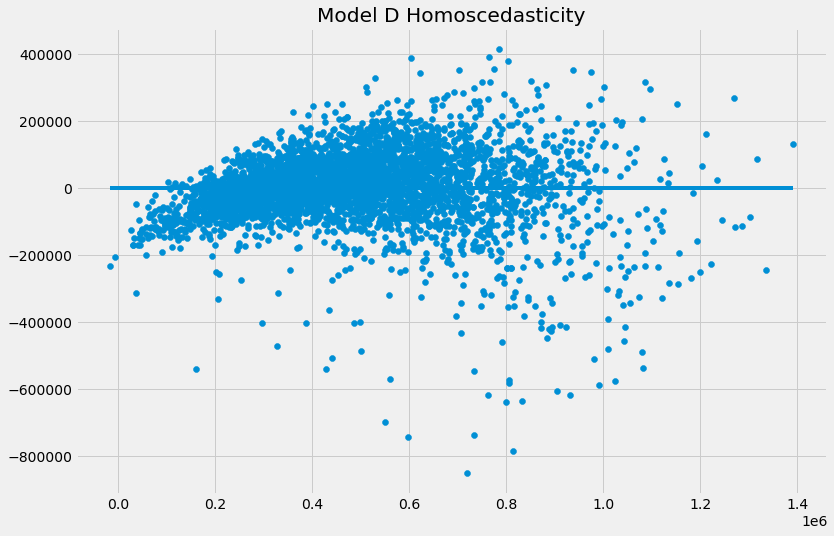

In [154]:
plot_scatter(y_test_pred_d, resid_d, 'Model D Homoscedasticity')

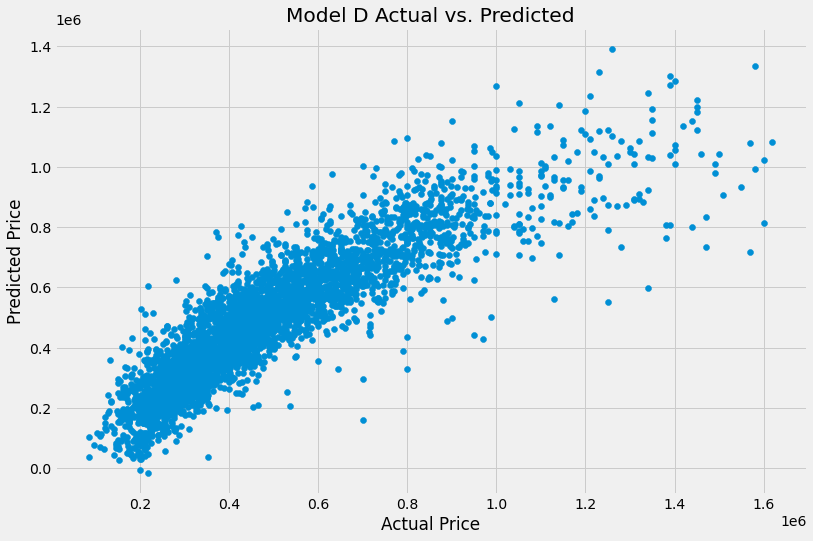

In [115]:
plot_model(y_test_d, y_test_pred_d, 'Model D Actual vs. Predicted')

## Model Comparison

In [116]:
data = {'R-Squared':[.546, .668, .756, .804],
       'Skew':[3.045, 4.983, 1.292, 1.292],
       'Kurtosis':[30.845, 69.1, 8.668, 9.157],
       'MAE (test)':['160,590', '122,502', '91,518', '77,473'],
       'MSE (test)':['60,591,750,008', '46,626,531,192', '18,263,182,375', '12,325,876,561'],
       'RMSE (test)':['246,153', '215,931', '135,141', '111,021']}
model_comparison = pd.DataFrame(data, index=['Model A', 'Model B', 'Model C', 'Model D'])
model_comparison

,R-Squared,Skew,Kurtosis,MAE (test),MSE (test),RMSE (test)
Model A,0.546,3.045,30.845,"160,590","60,591,750,008","246,153"
Model B,0.668,4.983,69.100,"122,502","46,626,531,192","215,931"
Model C,0.756,1.292,8.668,"91,518","18,263,182,375","135,141"
Model D,0.804,1.292,9.157,"77,473","12,325,876,561","111,021"


## Model Selection

Based on the model comparison above, Model D seems to most accurate of the group with the highest R-Squared, as well as lowest MAE, MSE, and RMSE. 

In [117]:
#Will run Model D with all the of the data without splitting.
final_model = pd.concat([price_d, scaled_bath_d, scaled_distance, scaled_grade_d, 
                     scaled_sqft_liv, updated_zip_d, scaled_yr_d], axis=1)

In [118]:
target_e = final_model['price']
features_e = final_model.drop(['price'], axis=1)

In [119]:
outcome_e = 'price'
predictors_e = final_model.drop(['price'], axis=1)
pred_sum_e = '+'.join(predictors_e.columns)
formula_e = outcome_e + '~' + pred_sum_e

In [120]:
final_model_ols = ols(formula=formula_e, data=final_model).fit()
final_model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1418.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:41:07   Log-Likelihood:            -2.6275e+05
No. Observations:               20150   AIC:                         5.256e+05
Df Residuals:                   20092   BIC:                         5.261e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.545e+05   3285.809    107.884      0.000    3.48e+05    3.61e+05
bathrooms              1.949e+04   1235.980     15.771      0.000    1.71e+04    2.19e+04
Distance_From_Seattle   -1.6e+04   2508.652     -6.378      0.000   -2.09e+04   -1.11e+04
grade                  6.399e+04   1373.447     46.589      0.000    6.13e+04    6.67e+04
sum_sqft_liv           1.025e+05   1464.286     70.007      0.000    9.96e+04    1.05e+05
zip_98004               5.44e+05   8402.443     64.744      0.000    5.28e+05     5.6e+05
zip_98005              2.641e+05   9740.868     27.111      0.000    2.45e+05    2.83e+05
zip_98006              2.331e+05   6186.800     37.675      0.000    2.21e+05    2.45e+05
zip_98007              2.011e+05   1.01e+04     19.871      0.000    1.81e+05    2.21e+05
zip_98008               2.12e+05   7470.782     28.371      0.000    1.97e+05    2.27e+05
zip_98010              1.033e+05   1.29e+04      7.981      0.000    7.79e+04    1.29e+05
zip_98011              6.574e+04      1e+04      6.567      0.000    4.61e+04    8.54e+04
zip_98014              1.164e+05   1.27e+04      9.154      0.000    9.15e+04    1.41e+05
zip_98019              4.649e+04   9514.915      4.886      0.000    2.78e+04    6.51e+04
zip_98024              1.309e+05   1.71e+04      7.660      0.000    9.74e+04    1.64e+05
zip_98027               1.58e+05   6358.806     24.851      0.000    1.46e+05     1.7e+05
zip_98028              6.632e+04   9137.397      7.258      0.000    4.84e+04    8.42e+04
zip_98029              1.804e+05   6691.991     26.954      0.000    1.67e+05    1.93e+05
zip_98033              3.032e+05   7261.820     41.755      0.000    2.89e+05    3.17e+05
zip_98034              1.355e+05   7253.665     18.687      0.000    1.21e+05     1.5e+05
zip_98039              7.387e+05   2.74e+04     26.954      0.000    6.85e+05    7.92e+05
zip_98040              4.329e+05   8183.336     52.904      0.000    4.17e+05    4.49e+05
zip_98045              1.099e+05   8729.196     12.587      0.000    9.28e+04    1.27e+05
zip_98052              1.898e+05   6333.194     29.970      0.000    1.77e+05    2.02e+05
zip_98053              1.979e+05   7168.336     27.610      0.000    1.84e+05    2.12e+05
zip_98056              8.451e+04   6067.978     13.926      0.000    7.26e+04    9.64e+04
zip_98059               6.84e+04   5730.964     11.936      0.000    5.72e+04    7.96e+04
zip_98065              1.002e+05   6988.555     14.344      0.000    8.65e+04    1.14e+05
zip_98070              1.442e+05   1.37e+04     10.518      0.000    1.17e+05    1.71e+05
zip_98072               1.02e+05   9067.598     11.251      0.000    8.42e+04     1.2e+05
zip_98074              1.482e+05   6323.598     23.438      0.000    1.36e+05    1.61e+05
zip_98075              

In [121]:
final_model_e = LinearRegression()
final_model_e.fit(features_e, target_e)

LinearRegression()

In [122]:
y_pred_e = final_model_e.predict(features_e)

In [123]:
print('Train Mean Absolute Error:',metrics.mean_absolute_error(target_e, y_pred_e))

Train Mean Absolute Error: 77528.77491863696


In [124]:
print('Train Mean Squared Error:',metrics.mean_squared_error(target_e, y_pred_e))

Train Mean Squared Error: 12404565078.45852


In [125]:
print('Train Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(target_e, y_pred_e)))

Train Root Mean Squared Error: 111375.78317775602


Running the model with all of the data produces a result very similar to the Model D results. This indicates that this model does not appear to be overfitting the data.

## Conclusions/Summary

Overall it appears that both Zip Codes and Square foot living, Square foot above, and Sum square foot living tend to be the most important factors in determining the actual price of homes. In models B, C, and D these two features produce the highest coeffiecients indicating that they have the stongest relationship with the dependent variable of price. This finding remains true as the models become more accurate and the data becomes more normally distributed accross different models. One interestering finding is that in model A we observed that Square foot living appeared to be the lowest coeffiecient, however this is likely due to the fact that the features were not scaled in this particular model, whereas in models B, C, and D all features were scaled before running the models.  

## Model D Graphs of Features vs. Price

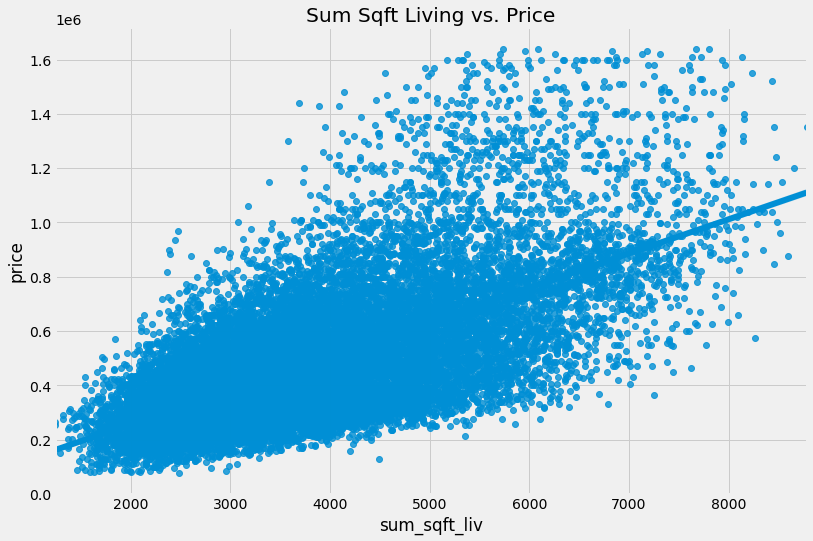

In [126]:
x = df_outliers_2['sum_sqft_liv']
y = df_outliers_2['price']
plt.figure(figsize=(12,8))
plt.xlabel('Sum Sqft Living')
plt.ylabel('Home Price')
plt.title('Sum Sqft Living vs. Price')
sns.regplot(x, y);

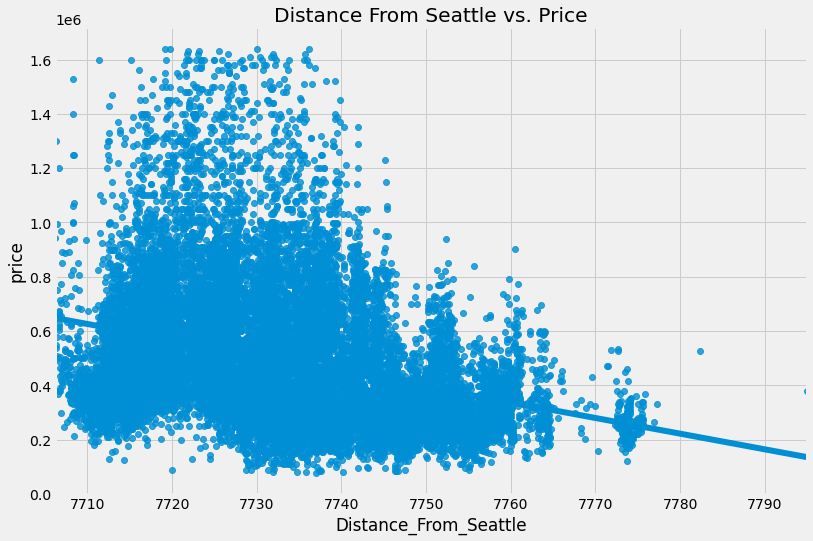

In [127]:
x = homes_lat_long['Distance_From_Seattle']
y = df_outliers_2['price']
plt.figure(figsize=(12,8))
plt.xlabel('Distance')
plt.ylabel('Home Price')
plt.title('Distance From Seattle vs. Price')
sns.regplot(x, y);

In [128]:
grouped_grade = df_outliers_2.groupby('grade').mean()
grouped_grade.reset_index(inplace=True)
grouped_grade

,grade,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,yr_built,sqft_living15,sqft_lot15,lat,long,sum_sqft_liv
0,3,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,1.000000,5.000000,520.000000,1920.000000,1340.000000,12233.000000,47.208200,-121.995000,1860.000000
1,4,2.120019e+05,1.592593,0.907407,680.740741,15614.777778,1.037037,3.148148,673.333333,1936.259259,1486.666667,12896.629630,47.496170,-122.165148,2167.407407
2,5,2.437212e+05,2.395556,1.124444,978.364444,10106.746667,1.075556,3.511111,936.720000,1934.262222,1360.346667,10467.017778,47.502182,-122.213076,2338.711111
3,6,3.004850e+05,2.682644,1.239531,1182.631685,8329.686176,1.108224,3.548940,1060.195762,1942.294147,1373.367306,8421.163976,47.534891,-122.267879,2555.998991
4,7,4.003124e+05,3.238859,1.819682,1676.301065,8299.268988,1.296712,3.493527,1396.764349,1963.453431,1669.359262,8340.751976,47.554889,-122.236704,3345.660328
5,8,5.368636e+05,3.462474,2.336318,2162.143934,8926.334133,1.672635,3.351953,1848.586703,1980.558430,2055.413811,8602.273646,47.567652,-122.211941,4217.557745
6,9,7.444790e+05,3.761763,2.637240,2800.955914,11297.429419,1.860110,3.255617,2511.057652,1989.166172,2582.822806,11014.064858,47.578687,-122.172833,5383.778720
7,10,9.293552e+05,3.822892,2.869880,3303.001205,14465.239759,1.900602,3.184337,2964.448193,1991.112048,2942.080723,13921.365060,47.596387,-122.154441,6245.081928
8,11,1.086702e+06,3.928571,3.051948,3727.071429,16705.168831,1.938312,3.155844,3391.032468,1994.149351,3316.389610,16496.383117,47.595068,-122.156403,7043.461039
9,12,1.372857e+06,3.428571,3.178571,4397.142857,20059.428571,1.714286,3.142857,4317.142857,1991.000000,3711.428571,20004.000000,47.571529,-122.166429,8108.571429


In [129]:
grouped_baths = df_outliers_2.groupby('bathrooms').mean()
grouped_baths.reset_index(inplace=True)
grouped_baths.head()

,bathrooms,price,bedrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,lat,long,sum_sqft_liv
0,0.50,237375.000000,2.250000,1235.000000,5465.500000,1.250000,3.250000,6.250000,992.500000,1948.000000,1545.000000,5844.750000,47.546050,-122.279500,2780.000000
1,0.75,294409.731343,1.925373,900.477612,13300.253731,1.082090,3.537313,5.641791,837.492537,1942.507463,1426.895522,14813.820896,47.539572,-122.228806,2327.373134
2,1.00,346737.642195,2.638219,1179.002915,8029.427776,1.111317,3.457726,6.571694,1091.789822,1944.304797,1442.077922,8172.005566,47.564876,-122.276953,2621.080838
3,1.25,621772.222222,2.222222,1525.555556,4643.777778,1.888889,3.444444,8.000000,1248.888889,1982.555556,1670.000000,5131.666667,47.617211,-122.262111,3195.555556
4,1.50,408877.277305,3.034752,1537.553191,8067.114184,1.352837,3.481560,7.135461,1341.378723,1959.861702,1608.661702,7974.921277,47.562613,-122.261999,3146.214894


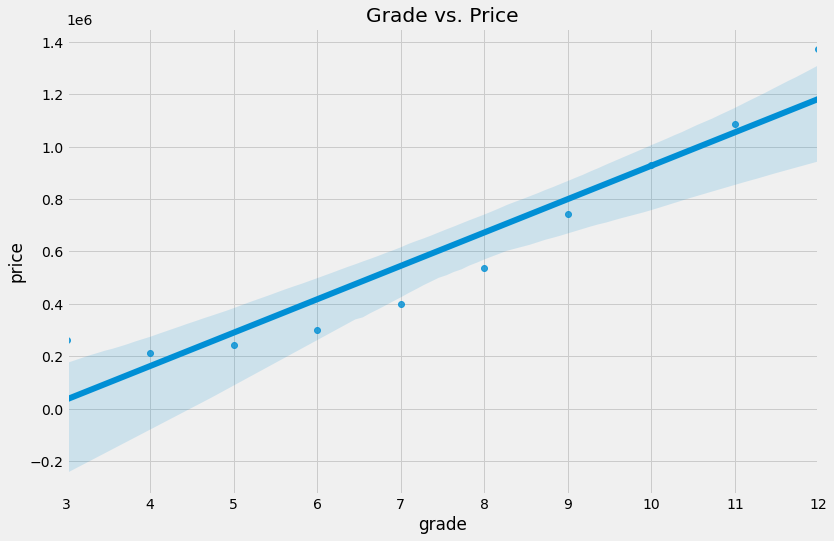

In [130]:
x = grouped_grade['grade']
y = grouped_grade['price']
plt.figure(figsize=(12,8))
plt.xlabel('Grade')
plt.ylabel('Home Price')
plt.title('Grade vs. Price')
sns.regplot(x, y);

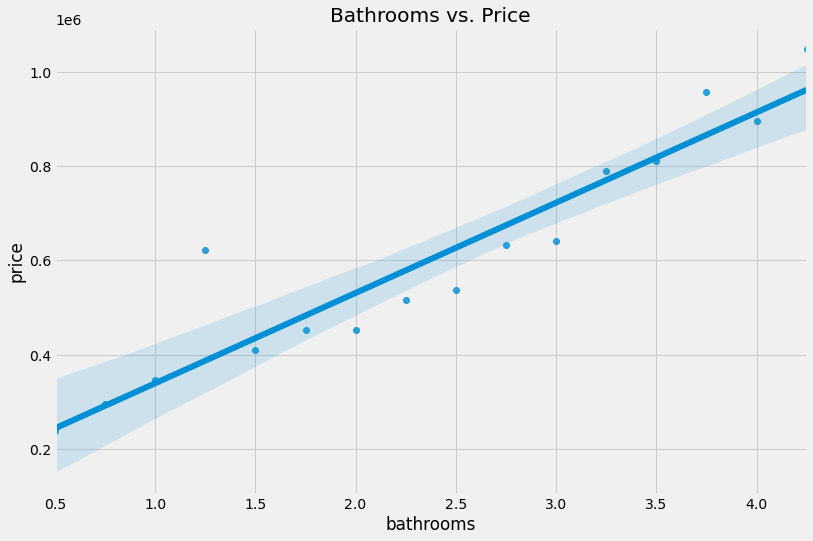

In [131]:
x = grouped_baths['bathrooms']
y = grouped_baths['price']
plt.figure(figsize=(12,8))
plt.xlabel('Bathrooms')
plt.ylabel('Home Price')
plt.title('Bathrooms vs. Price')
sns.regplot(x, y);